In [ ]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
MIN_INT = -sys.maxsize - 1

#MOUNTED COLAB

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#Hex World

In [ ]:
class MDP:
    def __init__(self,Y,S,A,T,R):
        self.Y = Y #discount factor
        self.S = S #state space
        self.A = A #action
        self.T = T #transition function
        self.R = R #reward function

In [ ]:
#6 direction can take in one action
#const variable
ACTIONS = ["→", "↗", "↖", "←", "↙", "↘"]
MOVEMENTS = [(1,0),(0,1),(-1,1),(-1,0),(0,-1),(1,-1)]

terminal_state = (MIN_INT,MIN_INT)
MOVE_TO_ARROWS = {MOVEMENTS[i] : ACTIONS[i] for i in range(len(ACTIONS))}

DS for a HexWorld MDP

In [ ]:
class HexWorldMDP:
    #constructor
    def __init__(self,y,p_transision,reward_bump_border,hexes,rewards): 
        '''y (float) -> discount factor
        p_transition (float) -> probablity of transition to correct next state
        reward_bump_border (float) -> reward if go outside of the hex world
        hexes (vector{state}) -> all state in hex world
        rewards (dict{state,real}) -> reward in absorbing hex
        '''
        self.T, self.R = self.constructTR(p_transision,reward_bump_border,hexes,rewards)
        self.mdp = MDP(y,hexes,MOVEMENTS,self.T,self.R)

    def constructTR(self,p_transition,reward_bump_border,hexes,rewards):
        nS = len(hexes) + 1 #add one terminal state
        nA = len(MOVEMENTS) #6 action

        p_veer = (1 - p_transition)/2 #unintended probablity
        R = {} #R = {('state','action'):'real'}
        T = {} #T = {('state','action','state'),'real}

        for s in hexes:
            if s in rewards.keys():
               for a in MOVEMENTS:
                   #s_ = s + a
                   ax,ay = a
                   sx,sy = s
                   
                   s_ = (sx + ax,sy + ay)
                   T[(s,a,s_)] = 0.0
                   T[(s,a,terminal_state)] = 1.0
                   self.updateR(R,(s,a),rewards[s])
            else:
                for idx,a in enumerate(MOVEMENTS):
                    #s_ = s + a
                    ax,ay = a
                    sx,sy = s
                    
                    s_ = (sx + ax,sy + ay)
                    self.updateR(R,(s,a),0.0)
                    self.updateT(T,(s,a,s_),0.0)

                    if s_ not in hexes: #out of the map
                       s_ = s
                       self.updateR(R, (s, a),reward_bump_border * p_transition)
                    self.updateT(T,(s,a,s_),p_transition)

                    x,y = MOVEMENTS[(idx + 1) % nA]
                    s_ = (sx + x,sy + y)
                    if s_ not in hexes: #out of the map
                       s_ = s
                       self.updateR(R, (s, a),reward_bump_border * p_veer)
                    self.updateT(T,(s,a,s_),p_veer)

                    x,y = MOVEMENTS[(idx - 1) % nA]
                    s_ = (sx + x,sy + y)
                    if s_ not in hexes: #out of the map
                       s_ = s
                       self.updateR(R, (s, a),reward_bump_border * p_veer)
                    self.updateT(T,(s,a,s_),p_veer)
        for a in MOVEMENTS:
             T[terminal_state, a, terminal_state] = 1.0
        return T,R  
    def updateR(self,R,key,value):
        if key not in R.keys():
           R[key] = 0.0
        R[key] += value
    
    def updateT(self,T,key,value):
        if key not in T.keys():
           T[key] = 0.0
        T[key] += value      

In [ ]:
#functuion for hex world mdp
def inbounds(hexMDP,s):
    return (s in hexMDP.mdp.S)

def T(mdp,s,a,s_):
    if (s,a,s_) not in mdp.T.keys():
       return 0.0
    return mdp.T[(s,a,s_)]

def R(mdp,s,a):
    if (s,a) not in mdp.R.keys():
       return 0.0
    return mdp.R[(s,a)]

def is_terminal(s):
    return s == terminal_state

def n_states(mdp):
    return len(mdp.mdp.S) + 1 #plus one terminal

MDP - Value Iteration

In [ ]:
# computing lookahead state-action value from s given action a
def lookahead(P,U,s,a):
    #P is MDP object
    S,y = P.S, P.Y
    return R(P,s,a) + y * sum([T(P,s,a,s_) * U[i] for (i,s_) in enumerate(S)]) 

def iterative_policy_evalution(MDP,pi,max_iter):
    S,T,R,y = MDP.S, MDP.T, MDP.R, MDP.y
    U = [0.0 for _ in S]
    for k in range(max_iter):
        U = [lookahead(MDP,U,s,pi[s]) for s in S]
    return U

In [ ]:
# backup procedure improve value function U at state s
# return u, optimal policy aa for state s
def backup(P,U,s):
    u_top = MIN_INT
    i_top = -1
    for i,a in enumerate(P.A):
        u = lookahead(P,U,s,a)
        if u > u_top:
           u_top = u
           i_top = i
    return (u_top,P.A[i_top])

In [ ]:
# solve Hex world MDP, repeat until ||U - U′|| < δ
epsilon = 1e-16   # threshold

# return value function, and optimal policy for each state
def solve(P):
    S,y = P.mdp.S, P.mdp.Y
    U = [0] * len(S)
    pi = {} #Dict(state : action)
    iter = 0

    while True:
       iter += 1
       U_ = [0] * len(S)
       for i, s in enumerate(S):
            U_[i], pi[s] = backup(P.mdp, U, s)
       sub_U = [U_[i] - U[i] for i in range(len(U))]
       if np.linalg.norm(sub_U,2) < epsilon:
          break
       U = U_

    print("Total iter = ",iter)
    return U, pi

HexWorld Sample

In [ ]:
#sample 1:
discount = 0.5
reward_bump_border = -1.0
p_trans = 0.7

hexes = [   (0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (-1, 2), 
            (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), 
            (8, 2), (4, 1), (5, 0), (6, 0), (7, 0), (7, 1), (8, 1), (9, 0) ]

rewards = {
            (0,1) : -5.0,
            (2,0) : 5.0,
            (9,0) : 6.0,
            (2,4) : -1.0
          }

P = HexWorldMDP(discount, p_trans, reward_bump_border, hexes, rewards)

In [ ]:
#Sample 2:
discount = 0.9
reward_bump_border = -1.0
p_trans = 0.7

hexes = [   (0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (-1, 2), 
            (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), 
            (8, 2), (4, 1), (5, 0), (6, 0), (7, 0), (7, 1), (8, 1), (9, 0) ]

rewards = {
            (0,1) : 5.0,
            (2,0) : -10.0,
            (9,0) : 10.0
          }

P = HexWorldMDP(discount, p_trans, reward_bump_border, hexes, rewards)

In [ ]:
U, pi = solve(P)
U

Total iter =  45


[4.1377814603755985,
 4.290229357221428,
 -10.0,
 0.7114723767907958,
 5.0,
 4.308361926449785,
 3.357815247498474,
 4.137781460375598,
 4.290229357221427,
 3.746754035300551,
 3.0794914458400475,
 3.0134940431880213,
 3.7299216690908814,
 4.798163203867212,
 6.035966887020738,
 7.0443827019144685,
 6.912224111606099,
 3.0134940431880213,
 3.3712431652980976,
 4.382551604234304,
 5.554385192208003,
 6.912224111606099,
 8.219178082191782,
 10.0]

#SIMULATOR
function support simulate game

In [ ]:
def sample(items,weight): 
    sum = 0.0
    num = np.random.rand()
    save = -1
    for i in range(len(weight)):
        sum += weight[i]
        if sum > num:
           save = i
           break
    if save == -1:
       return items[0]
    return items[save]

def generate_start_state(mdp):
    return mdp.mdp.S[np.random.randint(0,n_states(mdp) - 1)]

def generate_next_state(hexMDP,s,a):
    A = hexMDP.mdp.A
    probability = []
    S_ = []

    for a_ in A:
        a_x, a_y = a_
        sx,sy = s
        s_x = sx + a_x
        s_y = sy + a_y
        s_ = (s_x,s_y)
        if T(hexMDP.mdp,s,a,s_) > 0.0:
           probability.append(T(hexMDP.mdp,s,a,s_))
           S_.append(s_)
    s_ = s
    if T(hexMDP.mdp, s, a, s_) > 0.0:
            probability.append(T(hexMDP.mdp, s, a, s_))
            S_.append(s_)
    # check if go to terminal state after receive reward
    if T(hexMDP.mdp,s,a,terminal_state) > 0.0:
       probability.append(T(hexMDP.mdp,s,a,terminal_state))
       S_.append(terminal_state)

    # random select in prob action
    s_ = sample(S_,probability)

    s_x,s_y = s_
    a_x = s_x - sx
    a_y = s_y - sy
    if s_ == s: #stay
       idx = -1
       for i in range(len(A)):
           temp_x,temp_y = A[i]
           if a_x == temp_x and a_y == temp_y:
              idx = i
              break
       before = (idx - 1) % 6
       after = (idx + 1) % 6
       for i in [before,after]:
           temp_x,temp_y = A[i]
           s_x = sx + temp_x
           s_y = sy + temp_y
           if inbounds(hexMDP,(s_x,s_y)) is False:
              a_ = A[i]
              break
    elif s_ == terminal_state:
        a_ = A[0]
    return s_,a_

def simulation(hexMDP, pi,start_state,show_step = False):
    S,R,T,y = hexMDP.mdp.S, hexMDP.mdp.R,hexMDP.mdp.T,hexMDP.mdp.Y
    if start_state not in S:
       return 0.0
    s = start_state
    total_reward = 0.0
    step = 0

    while True:
        if s in rewards.keys():
           total_reward += math.pow(y,step) * rewards[s] 
        # next state action by random 
        s_, a_ = generate_next_state(hexMDP, s, pi[s])
        # if stay -> bump the border
        if s_ == s:
           total_reward += math.pow(y,step) * reward_bump_border
        if show_step: # print out step and direction arrow
           sx,sy = s
           print('(',sx, ",", sy, ')')
           print(' ', MOVE_TO_ARROWS[pi[s]], ' ', MOVE_TO_ARROWS[a_], ' ', total_reward)
        if is_terminal(s_):
           break
        step += 1
        s = s_
    return total_reward      

In [ ]:
U, pi = solve(P)
a = simulation(P,pi,(4,1),show_step = False)
print(a)

Total iter =  45
2.299243401000001


#Monte Carlo Simulation

In [ ]:
def MonteCarloSimulation(hexMDP, num_iter):
    S = hexMDP.mdp.S
    start_state = generate_start_state(hexMDP)
    total = 0.0

    for iter in range(num_iter):
        total += simulation(hexMDP,pi,start_state)
    print("Numher of iteration: ",num_iter)
    print("Start state: ",start_state)
    print("Mean = ",total / num_iter)
    idx = 0
    for ele in S:
        idx += 1
        if ele == start_state:
           break
    if idx < len(U):
       print("Expected utility = ", U[idx])

In [ ]:
MonteCarloSimulation(P, 100000)

Numher of iteration:  100000
Start state:  (5, 2)
Mean =  4.795767614562825
Expected utility =  6.035966887020738


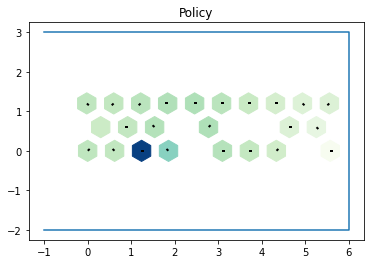

In [ ]:
def render(HexMDP,U,pi,tit = "",current_state = None):
    # constant setting plot
    diff_x = 0.62
    diff_y = 0.6
    diff_odd = 0.3

    DIRECT = [(1,0),(1,1),(-1,1),(-1,0),(-1,-1),(1,-1)]
    direct = {MOVEMENTS[i] : DIRECT[i] for i in range(len(DIRECT))}

    S = HexMDP.mdp.S
    R = HexMDP.mdp.R

    X = [(sx * diff_x + diff_odd * sy) for sx,sy in S]
    Y = [(sy * diff_y) for _,sy in S]
    # setup grad color
    def compute(u,R):
        return (u - np.min(list(R.values()))) / (np.max(list(R.values())) - np.min(list(R.values())))
    colors = [compute(u,R) for u in U]
    plt.scatter(X,Y,s = 450,marker = 'h',c = colors,cmap = "GnBu_r")
    plt.title(tit)

    if current_state != None:
       cur_x,cur_y = current_state
       plt.scatter([cur_x * diff_x + diff_odd * cur_y],[cur_y * diff_y],marker = 'h',markersize = 25,mec = 'g', mfc = 'g',alpha = 0.0)
    for s in S:
        s_x,s_y = s
        x = s_x * diff_x + diff_odd * s_y
        y = s_y * diff_y
        dx, dy = direct[pi[s]]
        dx /= 100; dy /= 100
        x += dx * 2
        y += dy * 2
        plt.plot([x, x + dx], [y, y + dy],'k',linewidth = 2)
    plt.plot([-1,6,6,-1],[-2,-2,3,3])
    plt.show()
    
render(P,U,pi,tit = "Policy")